In [8]:
#chack for updated files\n,
%load_ext autoreload
%autoreload 2
#import packages
from __future__ import division

import numpy as np
import glob, json
import pickle
import os as os_pack
import matplotlib.pyplot as plt
import corner
#%matplotlib inline\n",
%config InlineBackend.figure_format = 'retina'
import healpy as hp
import os, glob, json, pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as sl
import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const
from enterprise_extensions import blocks
from enterprise_extensions import models as ee_models
from enterprise_extensions import model_utils as ee_model_utils
from enterprise_extensions import model_orfs
from enterprise_extensions.frequentist import optimal_statistic as opt_stat
from enterprise_extensions import sampler as ee_sampler
from enterprise.signals.signal_base import LogLikelihood
import enterprise_wavelets as models
from enterprise.signals.deterministic_signals import Deterministic
from enterprise.signals.parameter import function
from la_forge.core import Core
from la_forge.diagnostics import plot_chains
from la_forge import rednoise
import la_forge
import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
#style
    
import Fast_Burst_likelihood as FB

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
#Loading in pickle and noise files
pint_pickle = '../../15yrCW/v1p1_de440_pint_bipm2019.pkl'
noise_file = '../../15yrCW/v1p1_wn_dict.json'
#psrlist = np.loadtxt('/home/reyna/15yr_v1p0/15yr_v1-20211001T235643Z-001/15yr_v1/psrlist_15yr_pint.txt', dtype = str)
with open(noise_file, 'r') as h:
    noise_params = json.load(h)
with open(pint_pickle,'rb') as f:
    allpsrs = pickle.load(f)
psrs = []
for ii,p in enumerate(allpsrs):
    psrs.append(p)
#Temporary to get code to not crash
psrs = psrs[0:8]
psrlist = [psr.name for psr in psrs]
print(psrlist)
for i in range(len(psrs)):
    print((max(psrs[i].toas) - min(psrs[i].toas))/(3.17*10**(7)))

['B1855+09', 'B1937+21', 'B1953+29', 'J0023+0923', 'J0030+0451', 'J0340+4130', 'J0406+3039', 'J0437-4715']
15.515060297068947
15.802872967471835
11.08458774068679
8.97542529762611
15.460752938661816
8.097196263848735
3.5471797714338695
4.73231500896138


In [57]:
glitches = []
log10_f0 = parameter.Uniform(np.log10(3.5e-9), np.log10(1e-7))("Glitch_"+str(1)+'_'+'log10_f0')
phase0 = parameter.Uniform(0, 2*np.pi)("Glitch_"+str(1)+'_'+'phase0')
tau = parameter.Uniform(0.2, 5)("Glitch_"+str(1)+'_'+'tau')
t0 = parameter.Uniform(0.0, 10.0)("Glitch_"+str(1)+'_'+'t0')
psr_idx = parameter.Uniform(-0.5, len(psrs)-0.5)("Glitch_"+str(1)+'_'+'psr_idx')
log10_h = parameter.LinearExp(-6.5, -5)("Glitch_"+str(1)+'_'+'log10_h')
glitch_wf = models.glitch_delay(log10_h = log10_h, tau = tau, log10_f0 = log10_f0, t0 = t0, phase0 = phase0, tref=53000*86400,
                                        psr_float_idx = psr_idx, pulsars=psrs)
glitches.append(deterministic_signals.Deterministic(glitch_wf, name='Glitch'+str(1) ))

In [58]:
tm = gp_signals.TimingModel(use_svd=True)
wn = blocks.white_noise_block(vary=False, inc_ecorr=False)
#s = base_model
s = tm + wn + glitches[0]
model = []
for p in psrs:
    model.append(s(p))
with open(noise_file, 'r') as fp:
    noisedict = json.load(fp)
    pta = signal_base.PTA(model)
    pta.set_default_params(noisedict)

In [59]:
d0 = parameter.sample(pta.params)
x0 = np.array([d0[par.name] for par in pta.params])

In [60]:
pta.get_lnlikelihood(x0)

729928.481336031

In [61]:
726231.1702248305
724566.2053894639

448209.3360017643

In [62]:
d0

{'Glitch_1_log10_f0': -7.756878408525551,
 'Glitch_1_log10_h': -5.264166700004374,
 'Glitch_1_phase0': 2.7528575556558974,
 'Glitch_1_psr_idx': -0.253086923663032,
 'Glitch_1_t0': 6.913254541763757,
 'Glitch_1_tau': 2.0302139073586076}

In [63]:
import Fast_Burst_likelihood as FB

In [64]:
FB1 = FB.FastBurst(pta = pta, psrs = psrs, params = d0, Npsr = len(psrs), tref=53000*86400)
#FB2 = FB.FastBurst(pta = pta, psrs = psrs, params = d0, Npsr = len(psrs), tref=53000*86400)

Nvecs arary:  [[1.69852389e-12 1.12772641e-10 3.26328092e-12 ... 4.85655692e-12
 5.14669141e-13 1.79238956e-12], [6.95185145e-14 1.57784257e-13 2.75345324e-14 ... 1.37317696e-13
 6.53510393e-13 3.42658995e-13], [4.94236756e-10 4.03404993e-10 7.90600715e-10 ... 2.03923984e-10
 4.69194849e-10 4.02505715e-10], [1.78150121e-13 6.22555077e-13 1.41224754e-13 ... 4.44123286e-11
 2.71409648e-11 3.12885720e-11], [4.61695300e-12 5.66353407e-11 6.83697178e-12 ... 9.39287544e-12
 1.01635764e-11 6.60318228e-12], [3.58685902e-11 2.77047195e-11 8.77407399e-11 ... 4.00248661e-11
 7.61997117e-11 4.82576810e-11], [2.30848299e-11 2.25095542e-12 6.90732193e-12 ... 1.26507575e-11
 3.65281122e-11 1.93290456e-11], [5.49729188e-12 4.98164427e-12 5.77752577e-12 ... 4.40088221e-12
 4.86261323e-12 1.46668814e-09], ...]
-23685595.61118301
logdet_phi:  15289.165017480458
logdet_sigma:  4448.603620972837
dotSigmaTNr:  6171.411084360541
logdet_phi:  25604.746234093782
logdet_sigma:  8639.864382479349
dotSigmaTNr:  4

In [65]:
FB1.get_lnlikelihood(10**(x0[1]), x0[2], 10**(x0[0]), (3.15*10**7)*x0[5], (3.15*10**7)*x0[4], x0[3])

Amplitude:  5.442936905362693e-06
Frequency:  1.750336670043231e-08
glitch_index:  -0.253086923663032
Old Sigma:  [0. 0.]
New sigma:  [-5.03683514e-06 -2.06297210e-06]
Old M and N:  [[0. 0.]
 [0. 0.]] [0. 0.]
Input time:  2520.4573850180363
Cosine:  [-2.37361327e-05 -2.37361327e-05 -2.37361327e-05 ... -6.99858185e-11
 -6.99858185e-11 -6.99858185e-11]
Sine:  [-1.96108530e-04 -1.96108530e-04 -1.96108530e-04 ...  1.11103219e-10
  1.11103219e-10  1.11103219e-10]
108185601493995.8
-6997592417447.869
-6997592417447.804
138110284558319.05
MM matrix: [[[ 1.08185601e+14 -6.99759242e+12]
  [-6.99759242e+12  1.38110285e+14]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]]

 [[ 0.0

724566.2053894639

In [17]:
%%time
NN = 50

log_L_olds = []
log_L_news = []

for i in range(NN):
    d0 = parameter.sample(pta.params)
    x0 = np.array([d0[par.name] for par in pta.params])
    
    log_L_olds.append(pta.get_lnlikelihood(x0))
    log_L_news.append(FB1.get_lnlikelihood(10**(x0[1]), x0[2], 10**(x0[0]),
                                           (3.15*10**7)*x0[5], (3.15*10**7)*x0[4], x0[3]))

log_L_olds = np.array(log_L_olds)
log_L_news = np.array(log_L_news)

Amplitude:  1.469781123501746e-06
Frequency:  5.8250706359702397e-08
glitch_index:  1.4059911383770038
Old Sigma:  [1.74986249e-07 9.90354825e-07]
New sigma:  [-1.39415782e-06 -4.65382134e-07]
Old M and N:  [[0. 0.]
 [0. 0.]] [0. 0.]
Input time:  3051.7058283026076
Cosine:  [0. 0. 0. ... 0. 0. 0.]
Sine:  [0. 0. 0. ... 0. 0. 0.]
0.0
0.0
0.0
0.0
MM matrix: [[[      0.               0.        ]
  [      0.               0.        ]]

 [[      0.               0.        ]
  [      0.               0.        ]]

 [[      0.               0.        ]
  [      0.               0.        ]]

 [[1742817.02432857 2496246.31854955]
  [2496246.31854955 7436897.60245038]]]
0.0
0.0
NN matrix: [[    0.            0.       ]
 [    0.            0.       ]
 [    0.            0.       ]
 [-2542.4521114 -5474.6166444]]
Cosine:  [1.77279454e-105 1.77279454e-105 1.77279454e-105 ... 1.07162311e-123
 1.07162310e-123 1.07162310e-123]
Sine:  [-1.62952028e-106 -1.62952028e-106 -1.62952027e-106 ...  1.84268420e

-22218402898200.027
-22218402898200.04
116395051772643.25
MM matrix: [[[ 7.12532033e+14 -2.22184029e+13]
  [-2.22184029e+13  1.16395052e+14]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]]

 [[ 2.99403820e+06  4.75753968e+06]
  [ 4.75753968e+06  1.87318257e+07]]]
248481579.51878998
16708291.663133064
NN matrix: [[2.48481580e+08 1.67082917e+07]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [8.50374757e+02 8.61058180e+03]]
Cosine:  [0. 0. 0. ... 0. 0. 0.]
Sine:  [0. 0. 0. ... 0. 0. 0.]
0.0
0.0
0.0
0.0
MM matrix: [[[ 7.12532033e+14 -2.22184029e+13]
  [-2.22184029e+13  1.16395052e+14]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]]

 [[ 2.99403820e+06  4.75753968e+06]
  [ 4.75753968e+06  1.87318257e+07]]]
0.0
0.0
NN matrix: [[2.48481580e+08 1.67082917e+07]
 [0.00000000e+

1.977659460767966e+16
-597661308304277.2
-597661308304280.2
2.095125146870306e+16
MM matrix: [[[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]]

 [[ 1.97765946e+16 -5.97661308e+14]
  [-5.97661308e+14  2.09512515e+16]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]]

 [[ 1.28434582e+14 -2.82673437e+12]
  [-2.82673437e+12  7.75625113e+13]]]
-6015723383.032687
9129580618.326582
NN matrix: [[ 0.00000000e+00  0.00000000e+00]
 [-6.01572338e+09  9.12958062e+09]
 [ 0.00000000e+00  0.00000000e+00]
 [ 2.42706518e+07 -2.93116441e+06]]
Cosine:  [0. 0. 0. ... 0. 0. 0.]
Sine:  [0. 0. 0. ... 0. 0. 0.]
0.0
0.0
0.0
0.0
MM matrix: [[[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]]

 [[ 1.97765946e+16 -5.97661308e+14]
  [-5.97661308e+14  2.09512515e+16]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]]

 [[ 1.28434582e+14 -2.82673437e+12]
  [-2.82673437e+12  7.75625113e+13]]]
0.0
0.0
NN matrix: [[ 0.00000000e+0

0.0
0.0
0.0
MM matrix: [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]
0.0
0.0
NN matrix: [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
Cosine:  [0. 0. 0. ... 0. 0. 0.]
Sine:  [0. 0. 0. ... 0. 0. 0.]
0.0
0.0
0.0
0.0
MM matrix: [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]
0.0
0.0
NN matrix: [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
Cosine:  [9.26586290e-02 9.26586294e-02 9.26586298e-02 ... 1.49201563e-11
 1.49201563e-11 1.49201563e-11]
Sine:  [-1.82194722e-01 -1.82194722e-01 -1.82194722e-01 ... -1.90759032e-11
 -1.90759032e-11 -1.90759032e-11]
156691928322.93362
53206257601.11563
53206257601.115776
226603375972.3348
MM matrix: [[[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]

 [[1.56691928e+11 5.32062576e+10]
  [5.32062576e+10 2.26603376e+11]]]
534784.736414257


0.0
0.0
0.0
0.0
MM matrix: [[[1.61028617e+14 1.61869009e+13]
  [1.61869009e+13 1.84282484e+14]]

 [[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]]
0.0
0.0
NN matrix: [[ 14590322.30945517 -32017128.04836964]
 [        0.                 0.        ]
 [        0.                 0.        ]
 [        0.                 0.        ]]
New M and N:  [[1.61028617e+14 1.61869009e+13]
 [1.61869009e+13 1.84282484e+14]] [ 14590322.30945517 -32017128.04836964]
adding in resres_logdet 282505.0128627308
LogL:  277857.89146398066
LogL:  277857.89146398066
LogL:  277857.89146398066
LogL:  277857.89146398066
Amplitude:  6.196183440007381e-06
Frequency:  8.316487934088116e-08
glitch_index:  2.1734214632086406
Old Sigma:  [-7.38753608e-06 -8.67126380e-07]
New sigma:  [-4.44347933e-06 -4.31835393e-06]
Old M and N:  [[1.61028617e+14 1.61869009e+13]
 

0.0
NN matrix: [[    0.             0.        ]
 [    0.             0.        ]
 [-7843.09867675 25251.93586976]
 [    0.             0.        ]]
New M and N:  [[0. 0.]
 [0. 0.]] [0. 0.]
adding in resres_logdet 282505.0128627308
LogL:  282505.0128627308
LogL:  282505.0128627308
LogL:  282505.1314178122
LogL:  282505.1314178122
Amplitude:  2.201664800412508e-06
Frequency:  5.38379342230853e-09
glitch_index:  0.9635934080452175
Old Sigma:  [-2.46678814e-06  4.03720024e-06]
New sigma:  [ 1.36671847e-06 -1.72609632e-06]
Old M and N:  [[0. 0.]
 [0. 0.]] [0. 0.]
Input time:  1381.7255248945896
Cosine:  [0. 0. 0. ... 0. 0. 0.]
Sine:  [0. 0. 0. ... 0. 0. 0.]
0.0
0.0
0.0
0.0
MM matrix: [[[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]

 [[4.69823637e+09 2.19050794e+09]
  [2.19050794e+09 1.25896228e+09]]

 [[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]]
0.0
0.0
NN matrix: [[    0.     

0.0
0.0
NN matrix: [[-20326764.88067664  26385758.06951237]
 [        0.                 0.        ]
 [        0.                 0.        ]
 [        0.                 0.        ]]
New M and N:  [[7.38123201e+14 1.11613851e+14]
 [1.11613851e+14 7.87968971e+14]] [-20326764.88067664  26385758.06951237]
adding in resres_logdet 282505.0128627308
LogL:  282164.3410969912
LogL:  282164.3410969912
LogL:  282164.3410969912
LogL:  282164.3410969912
Amplitude:  4.929847394071835e-06
Frequency:  2.218281710393691e-08
glitch_index:  0.03072930757893788
Old Sigma:  [-2.35069263e-07  9.77556595e-07]
New sigma:  [4.17509250e-06 2.62144958e-06]
Old M and N:  [[7.38123201e+14 1.11613851e+14]
 [1.11613851e+14 7.87968971e+14]] [-20326764.88067664  26385758.06951237]
Input time:  220.2962672493276
Cosine:  [-9.44267046e-02 -9.44267046e-02 -9.44267046e-02 ...  3.76573402e-14
  3.76573402e-14  3.76573402e-14]
Sine:  [9.78625006e-01 9.78625006e-01 9.78625006e-01 ... 7.43992998e-14
 7.43992998e-14 7.439929

0.0
0.0
0.0
0.0
MM matrix: [[[1.42529884e+14 3.81592689e+12]
  [3.81592689e+12 8.60997108e+13]]

 [[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]]
0.0
0.0
NN matrix: [[11959253.89379343 -2491781.39368761]
 [       0.                0.        ]
 [       0.                0.        ]
 [       0.                0.        ]]
New M and N:  [[1.42529884e+14 3.81592689e+12]
 [3.81592689e+12 8.60997108e+13]] [11959253.89379343 -2491781.39368761]
adding in resres_logdet 282505.0128627308
LogL:  279346.16040094686
LogL:  279346.16040094686
LogL:  279346.16040094686
LogL:  279346.16040094686
Amplitude:  1.92576887711936e-06
Frequency:  2.465779312346558e-08
glitch_index:  0.09099164804806126
Old Sigma:  [-6.55374486e-06 -4.61065040e-07]
New sigma:  [-1.91978491e-06  1.51695985e-07]
Old M and N:  [[1.42529884e+14 3.81592689e+12]
 [3.8159268

-72.53569375497239
3705.9944329063596
NN matrix: [[   0.            0.        ]
 [   0.            0.        ]
 [   0.            0.        ]
 [ -72.53569375 3705.99443291]]
New M and N:  [[0. 0.]
 [0. 0.]] [0. 0.]
adding in resres_logdet 282505.0128627308
LogL:  282505.0128627308
LogL:  282505.0128627308
LogL:  282505.0128627308
LogL:  282504.997664979
Amplitude:  8.4229086058528e-06
Frequency:  4.0557886493034593e-08
glitch_index:  1.1660560569974154
Old Sigma:  [ 3.61537314e-07 -4.08554747e-06]
New sigma:  [ 5.60690526e-06 -6.28553918e-06]
Old M and N:  [[0. 0.]
 [0. 0.]] [0. 0.]
Input time:  3001.390291272123
Cosine:  [0. 0. 0. ... 0. 0. 0.]
Sine:  [0. 0. 0. ... 0. 0. 0.]
0.0
0.0
0.0
0.0
MM matrix: [[[      0.               0.        ]
  [      0.               0.        ]]

 [[      0.               0.        ]
  [      0.               0.        ]]

 [[      0.               0.        ]
  [      0.               0.        ]]

 [[ 609642.84038551  828166.7561269 ]
  [ 828166.75612

0.0
0.0
0.0
0.0
MM matrix: [[[2.90795338e+14 6.01610191e+11]
  [6.01610191e+11 2.60463516e+14]]

 [[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]]
0.0
0.0
NN matrix: [[-1.43472143e+07  1.35348759e+08]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]]
New M and N:  [[2.90795338e+14 6.01610191e+11]
 [6.01610191e+11 2.60463516e+14]] [-1.43472143e+07  1.35348759e+08]
adding in resres_logdet 282505.0128627308
LogL:  281827.1113312678
LogL:  281827.1113312678
LogL:  281827.1113312678
LogL:  281827.1113312678
Amplitude:  7.0403267938691425e-06
Frequency:  2.271477237856879e-08
glitch_index:  0.9745062817194294
Old Sigma:  [3.05170661e-07 2.82914713e-06]
New sigma:  [1.61759735e-06 6.85197637e-06]
Old M and N:  [[2.90795338e+14 6.01610191e+11]
 [6.01610191e+11 2.60463516e+14]] [-1.

0.0
0.0
0.0
MM matrix: [[[   0.            0.        ]
  [   0.            0.        ]]

 [[   0.            0.        ]
  [   0.            0.        ]]

 [[5844.4907859  5405.93171469]
  [5405.93171469 7343.55971587]]

 [[   0.            0.        ]
  [   0.            0.        ]]]
0.0
0.0
NN matrix: [[  0.           0.        ]
 [  0.           0.        ]
 [-28.65854363 -23.50679973]
 [  0.           0.        ]]
Cosine:  [0. 0. 0. ... 0. 0. 0.]
Sine:  [0. 0. 0. ... 0. 0. 0.]
0.0
0.0
0.0
0.0
MM matrix: [[[   0.            0.        ]
  [   0.            0.        ]]

 [[   0.            0.        ]
  [   0.            0.        ]]

 [[5844.4907859  5405.93171469]
  [5405.93171469 7343.55971587]]

 [[   0.            0.        ]
  [   0.            0.        ]]]
0.0
0.0
NN matrix: [[  0.           0.        ]
 [  0.           0.        ]
 [-28.65854363 -23.50679973]
 [  0.           0.        ]]
Cosine:  [0. 0. 0. ... 0. 0. 0.]
Sine:  [0. 0. 0. ... 0. 0. 0.]
0.0
0.0
0.0
0.0
MM mat

0.0
0.0
0.0
MM matrix: [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]
0.0
0.0
NN matrix: [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
Cosine:  [0. 0. 0. ... 0. 0. 0.]
Sine:  [0. 0. 0. ... 0. 0. 0.]
0.0
0.0
0.0
0.0
MM matrix: [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]
0.0
0.0
NN matrix: [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
Cosine:  [0. 0. 0. ... 0. 0. 0.]
Sine:  [0. 0. 0. ... 0. 0. 0.]
0.0
0.0
0.0
0.0
MM matrix: [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]
0.0
0.0
NN matrix: [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
Cosine:  [4.05766204e-04 4.05766204e-04 4.05766204e-04 ... 5.42824815e-17
 5.42824815e-17 5.42824815e-17]
Sine:  [-4.74523129e-04 -4.74523129e-04 -4.74523129e-04 ... -2.08749820e-17
 -2.08749820e-17 -2.08749820e-17]
602096.9792954717
-370169.8677902715
-370169.86779027147
286964.08040956093
MM matrix: [[[      0.               0.        ]
  [      0.           

0.0
0.0
NN matrix: [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
Cosine:  [3.38455620e-02 3.38455620e-02 3.38455620e-02 ... 2.75858923e-25
 2.75858923e-25 2.75858923e-25]
Sine:  [-9.04189029e-02 -9.04189029e-02 -9.04189029e-02 ... -6.00959151e-25
 -6.00959148e-25 -6.00959145e-25]
25690673.89157306
-14115535.167140558
-14115535.16714052
81384599.48403083
MM matrix: [[[        0.                 0.        ]
  [        0.                 0.        ]]

 [[        0.                 0.        ]
  [        0.                 0.        ]]

 [[ 25690673.89157306 -14115535.16714052]
  [-14115535.16714056  81384599.48403083]]

 [[        0.                 0.        ]
  [        0.                 0.        ]]]
-618.0629834071246
-1910.0179809688266
NN matrix: [[    0.             0.        ]
 [    0.             0.        ]
 [ -618.06298341 -1910.01798097]
 [    0.             0.        ]]
Cosine:  [0. 0. 0. ... 0. 0. 0.]
Sine:  [0. 0. 0. ... 0. 0. 0.]
0.0
0.0
0.0
0.0
MM matrix: [[[        0.           

168820505.222266
-63350789.010864615
NN matrix: [[ 1.68820505e+08 -6.33507890e+07]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]]
Cosine:  [0. 0. 0. ... 0. 0. 0.]
Sine:  [0. 0. 0. ... 0. 0. 0.]
0.0
0.0
0.0
0.0
MM matrix: [[[2.52892325e+14 4.62143875e+13]
  [4.62143875e+13 1.64360665e+14]]

 [[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]]
0.0
0.0
NN matrix: [[ 1.68820505e+08 -6.33507890e+07]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]]
Cosine:  [0. 0. 0. ... 0. 0. 0.]
Sine:  [0. 0. 0. ... 0. 0. 0.]
0.0
0.0
0.0
0.0
MM matrix: [[[2.52892325e+14 4.62143875e+13]
  [4.62143875e+13 1.64360665e+14]]

 [[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00]
  [0.00000000e+

0.0
0.0
0.0
MM matrix: [[[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]]

 [[ 1.72741575e+12 -2.50657360e+11]
  [-2.50657360e+11  1.44390591e+12]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]]]
0.0
0.0
NN matrix: [[       0.                0.        ]
 [       0.                0.        ]
 [  161710.10228509 -5292702.17907144]
 [       0.                0.        ]]
Cosine:  [-0.07152385 -0.07152385 -0.07152385 ...  0.00250745  0.00250745
  0.00250745]
Sine:  [0.4463547  0.4463547  0.4463547  ... 0.01425336 0.01425336 0.01425336]
36445556380503.7
834179672689.4014
834179672689.4006
23499706727897.316
MM matrix: [[[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]

 [[3.64455564e+13 8.34179673e+11]
  [8.34179673e+11 2.34997067e+13]]

 [[0.00000000e+00 0.00000000e+00]
  [0.000000

0.0
0.0
0.0
0.0
MM matrix: [[[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]

 [[2.31631136e+14 5.01709464e+13]
  [5.01709464e+13 2.10285496e+14]]]
0.0
0.0
NN matrix: [[        0.                 0.        ]
 [        0.                 0.        ]
 [        0.                 0.        ]
 [  2219908.32037717 -21571559.07731608]]
Cosine:  [-1.18488054e-06 -1.18488054e-06 -1.18488054e-06 ... -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00]
Sine:  [2.89835178e-06 2.89835178e-06 2.89835178e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3701241418.28792
999701316.3745667
999701316.374567
484886246.4761459
MM matrix: [[[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]

 [[3.70124142e+09 9.99701316e+08]
  [9.99701316e+08 4.84886246e+08]]

 [

0.0
NN matrix: [[ 0.00000000e+00  0.00000000e+00]
 [ 1.08871447e+09 -2.06774430e+09]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]]
Cosine:  [0. 0. 0. ... 0. 0. 0.]
Sine:  [0. 0. 0. ... 0. 0. 0.]
0.0
0.0
0.0
0.0
MM matrix: [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]
0.0
0.0
NN matrix: [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
Cosine:  [0. 0. 0. ... 0. 0. 0.]
Sine:  [0. 0. 0. ... 0. 0. 0.]
0.0
0.0
0.0
0.0
MM matrix: [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]
0.0
0.0
NN matrix: [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
Cosine:  [-1.08080435e-01 -1.08080435e-01 -1.08080435e-01 ...  1.65580447e-15
  1.65580447e-15  1.65580447e-15]
Sine:  [ 2.24583202e-02  2.24583202e-02  2.24583202e-02 ... -4.23318737e-15
 -4.23318737e-15 -4.23318737e-15]
46485401949.09833
7317290195.159112
7317290195.159103
4143098547.5361853
MM matrix: [[[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]

Text(0, 0.5, 'QuickBurst log(likelihood)')

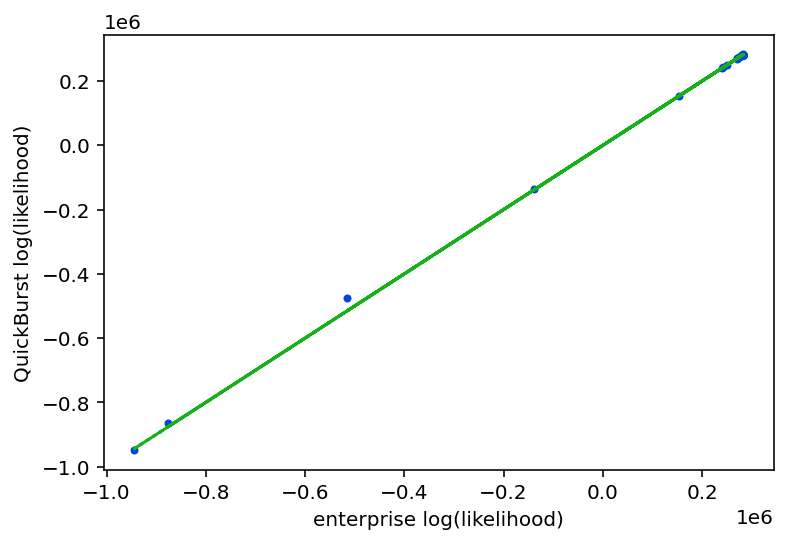

In [20]:
plt.plot(log_L_olds, log_L_news, ls='', marker='.', color='xkcd:blue')
plt.plot(log_L_olds, log_L_olds, ls='--', color='xkcd:green')
plt.xlabel("enterprise log(likelihood)")
plt.ylabel("QuickBurst log(likelihood)")

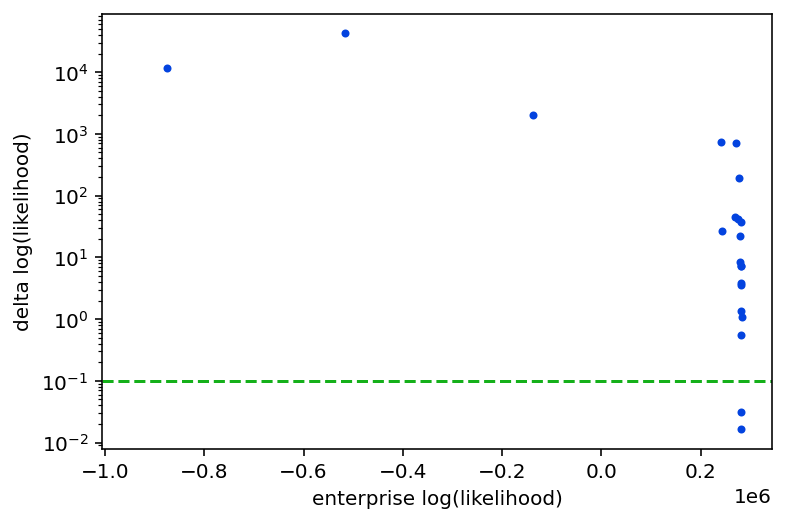

In [24]:
plt.plot(log_L_olds, log_L_news-log_L_olds, ls='', marker='.', color='xkcd:blue')
plt.gca().axhline(0.1, ls='--', color='xkcd:green')
plt.xlabel("enterprise log(likelihood)")
plt.ylabel("delta log(likelihood)")
plt.yscale('log')